In [11]:
! mkdir -p data && wget -O ./data/lenta_40k.csv.zip https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip

--2024-02-07 09:52:10--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip [following]
--2024-02-07 09:52:10--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘./data/lenta_40k.csv.zip’

./data/lenta_40k.cs 100%[===================>]  29.24M  42.9MB/s    in 0.7s    

2024-02-07 09:52:11 (42.9 MB/s) - ‘./da

## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [6]:
df = pd.read_csv("data/lenta_40k.csv.zip")

In [7]:
df

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [8]:
df.dropna(subset=['topic', 'text'], inplace=True)

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
# словарь
vocab = Counter()

for text in df.text:
    vocab.update(preprocess(text))

In [12]:
len(vocab)

354611

In [13]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 20:
        filtered_vocab.add(word)

In [14]:
len(filtered_vocab)

32156

In [15]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i:word for word, i in word2id.items()}

In [17]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [18]:
MAX_LEN = 200

In [22]:
texts = df.text.values
id2label = {i:l for i,l in enumerate(set(df.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in df.topic]

In [23]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.15)

In [25]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
train_data = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [24]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False)

In [99]:
from sklearn.metrics import f1_score
from copy import deepcopy

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            
            
            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

            if epoch_f1[-1] > max(f1s_eval, default=0):
                model.best_state = deepcopy(model.state_dict())
            
    return np.mean(epoch_f1)# / len(iterator)

In [100]:
# сеть с двумя полносвязными слоями и активацией
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden, output_dim):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden)
        self.fc_1 = nn.Linear(hidden, hidden*3)
        self.act = nn.LogSoftmax(1) 
        self.fc_2 = nn.Linear(hidden*3, output_dim)
        self.relu = nn.ReLU()       
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 

        outputs=self.act(dense_outputs)
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 30, len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [101]:
import torchsummary

In [102]:
torchsummary.summary(model, (1, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1           [-1, 1, 256, 30]         964,710
            Linear-2              [-1, 256, 30]             930
              ReLU-3              [-1, 256, 30]               0
            Linear-4              [-1, 256, 90]           2,790
        LogSoftmax-5              [-1, 256, 90]               0
Total params: 968,430
Trainable params: 968,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 3.69
Estimated Total Size (MB): 4.22
----------------------------------------------------------------


Запускаем обучение

In [77]:
EPOCHS = 20

In [103]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "w") as f:
    f.write(f"Model {model._get_name()} f1-score is {evl}")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 3.488308606147766; F1 measure: 0.130078125


  5%|▌         | 1/20 [00:01<00:22,  1.18s/it]

Eval f1-measure:  0.20635457677165356
1
Loss: 2.311487910747528; F1 measure: 0.223515625


 10%|█         | 2/20 [00:02<00:21,  1.17s/it]

Eval f1-measure:  0.21536545086311326
2
Loss: 2.2172960782051088; F1 measure: 0.23328125


 15%|█▌        | 3/20 [00:03<00:20,  1.19s/it]

Eval f1-measure:  0.2574445885069655
3
Loss: 2.0538642263412474; F1 measure: 0.3284375


 20%|██        | 4/20 [00:04<00:18,  1.18s/it]

Eval f1-measure:  0.38608939657783165
4
Loss: 1.7601272714138032; F1 measure: 0.4452734375


 25%|██▌       | 5/20 [00:05<00:17,  1.18s/it]

Eval f1-measure:  0.5034720907783161
5
Loss: 1.4896282029151917; F1 measure: 0.536171875


 30%|███       | 6/20 [00:07<00:16,  1.17s/it]

Eval f1-measure:  0.5613347497728649
6
Loss: 1.3149406278133393; F1 measure: 0.593359375


 35%|███▌      | 7/20 [00:08<00:15,  1.16s/it]

Eval f1-measure:  0.6040148489551787
7
Loss: 1.1979370325803758; F1 measure: 0.6339453125


 40%|████      | 8/20 [00:09<00:13,  1.15s/it]

Eval f1-measure:  0.6330147921714112
8
Loss: 1.084039043188095; F1 measure: 0.670703125


 45%|████▌     | 9/20 [00:10<00:12,  1.15s/it]

Eval f1-measure:  0.6525495911568746
9
Loss: 0.9986419188976288; F1 measure: 0.69546875


 50%|█████     | 10/20 [00:11<00:11,  1.16s/it]

Eval f1-measure:  0.6737382173682617
10
Loss: 0.9286663192510605; F1 measure: 0.7179296875


 55%|█████▌    | 11/20 [00:13<00:11,  1.23s/it]

Eval f1-measure:  0.6838090551181103
11
Loss: 0.8747730123996734; F1 measure: 0.735859375


 60%|██████    | 12/20 [00:14<00:09,  1.21s/it]

Eval f1-measure:  0.6965794878104179
12
Loss: 0.8201582872867584; F1 measure: 0.7524609375


 65%|██████▌   | 13/20 [00:15<00:08,  1.20s/it]

Eval f1-measure:  0.7086069995457299
13
Loss: 0.7752294033765793; F1 measure: 0.765


 70%|███████   | 14/20 [00:16<00:07,  1.20s/it]

Eval f1-measure:  0.7128089983343429
14
Loss: 0.7259188455343246; F1 measure: 0.7787890625


 75%|███████▌  | 15/20 [00:17<00:05,  1.20s/it]

Eval f1-measure:  0.7242331825408843
15
Loss: 0.6830615013837814; F1 measure: 0.7939453125


 80%|████████  | 16/20 [00:18<00:04,  1.19s/it]

Eval f1-measure:  0.727842500757117
16
Loss: 0.6427914953231811; F1 measure: 0.806015625


 85%|████████▌ | 17/20 [00:20<00:03,  1.18s/it]

Eval f1-measure:  0.7344578096608116
17
Loss: 0.6103204363584518; F1 measure: 0.816328125


 90%|█████████ | 18/20 [00:21<00:02,  1.17s/it]

Eval f1-measure:  0.7374638003482737
18
Loss: 0.5758958956599236; F1 measure: 0.8244140625


 95%|█████████▌| 19/20 [00:22<00:01,  1.17s/it]

Eval f1-measure:  0.7385095680648093
19
Loss: 0.547370254099369; F1 measure: 0.8344140625


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

Eval f1-measure:  0.7431729349636584


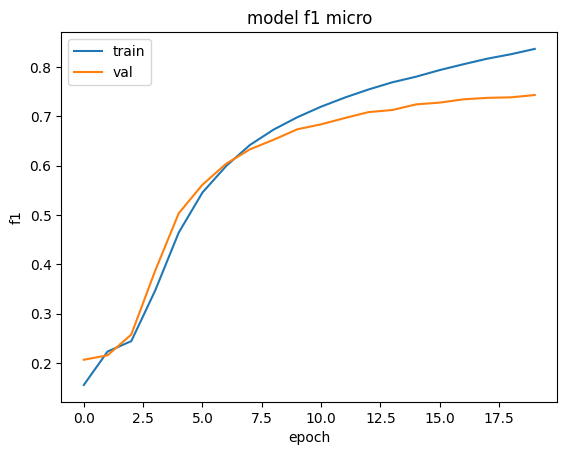

In [104]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посмотрим еще максимальную f меру

In [105]:
max(f1s_eval)

0.7431729349636584

Теперь попробуем сверточные слои. В торче сверточные слои не очень простые - нужно подробно разобраться в параметрах и расчитывать изменения в размере последовательности вручную. 

In [110]:
class Conv1(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim = 100, ker_size = 7, stride = 1, hidden_layer = 64, max_len = 200):
        
        super().__init__() 

        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.KERNEL_SIZE = ker_size
        self.MAX_LEN = max_len
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = output_dim
        self.STRIDE = stride
        self.HIDDEN_FC = hidden_layer
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
    
        self.relu = nn.ReLU()
        
        
        self.flattened_size = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1)*self.OUT_CHANNELS)
        
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        
        embedded = self.embedding(text).permute(0, 2, 1)
        
        convoluted = self.relu(self.conv(embedded))
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = self.relu(self.fc(hidden))  
        
        dense_outputs = self.fc_1(hidden) 
        outputs=self.act(dense_outputs) 
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Conv1(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [116]:
torchsummary.summary(model, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 200, 100]       3,215,700
            Conv1d-2              [-1, 19, 194]          13,319
              ReLU-3              [-1, 19, 194]               0
            Linear-4                   [-1, 64]         235,968
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 19]           1,235
        LogSoftmax-7                   [-1, 19]               0
Total params: 3,466,222
Trainable params: 3,466,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 13.22
Estimated Total Size (MB): 13.43
----------------------------------------------------------------


In [107]:
import gc
from tqdm import tqdm

f1s = []
f1s_eval = []

for i in tqdm(range(EPOCHS)):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval f1-measure: ', evl)
    f1s_eval.append(evl)


model.load_state_dict(model.best_state)
evl = evaluate(model, valid_data, criterion)

with open("models/model_results.txt", "a") as f:
    f.writelines(f"Model {model._get_name()} f1-score is {evl}\n")
torch.save(model, f"models/'{model._get_name()}'.pt")

del model
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

0
Loss: 2.20754679441452; F1 measure: 0.265546875


  5%|▌         | 1/20 [00:05<01:47,  5.66s/it]

Eval f1-measure:  0.4933988870381587
1
Loss: 1.3379059481620788; F1 measure: 0.5824609375


 10%|█         | 2/20 [00:11<01:39,  5.55s/it]

Eval f1-measure:  0.6076123372198667
2
Loss: 0.944161610007286; F1 measure: 0.705


 15%|█▌        | 3/20 [00:16<01:33,  5.48s/it]

Eval f1-measure:  0.6399270328588733
3
Loss: 0.6805279082059861; F1 measure: 0.78921875


 20%|██        | 4/20 [00:22<01:28,  5.53s/it]

Eval f1-measure:  0.6433837447001818
4
Loss: 0.4679592406749725; F1 measure: 0.8594140625


 25%|██▌       | 5/20 [00:27<01:22,  5.51s/it]

Eval f1-measure:  0.6548055629164142
5
Loss: 0.29244456231594085; F1 measure: 0.918984375


 30%|███       | 6/20 [00:33<01:19,  5.65s/it]

Eval f1-measure:  0.6594618318443367
6
Loss: 0.15518462039530279; F1 measure: 0.9659765625


 35%|███▌      | 7/20 [00:39<01:15,  5.81s/it]

Eval f1-measure:  0.6490987942913387
7
Loss: 0.07720282569527626; F1 measure: 0.9873828125


 40%|████      | 8/20 [00:45<01:09,  5.80s/it]

Eval f1-measure:  0.654959352286493
8
Loss: 0.03729600565508008; F1 measure: 0.99640625


 45%|████▌     | 9/20 [00:50<01:02,  5.71s/it]

Eval f1-measure:  0.6534581314354936
9
Loss: 0.01949319667182863; F1 measure: 0.9980078125


 50%|█████     | 10/20 [00:56<00:57,  5.73s/it]

Eval f1-measure:  0.6579653429739551
10
Loss: 0.013073232853785158; F1 measure: 0.998359375


 55%|█████▌    | 11/20 [01:02<00:52,  5.88s/it]

Eval f1-measure:  0.6569089283010296
11
Loss: 0.009517715256661176; F1 measure: 0.9986328125


 60%|██████    | 12/20 [01:09<00:48,  6.03s/it]

Eval f1-measure:  0.6597694105844943
12
Loss: 0.007377194485161454; F1 measure: 0.998984375


 65%|██████▌   | 13/20 [01:15<00:42,  6.07s/it]

Eval f1-measure:  0.6596144382192611
13
Loss: 0.005864523483905941; F1 measure: 0.998984375


 70%|███████   | 14/20 [01:21<00:35,  5.95s/it]

Eval f1-measure:  0.6611203910508782
14
Loss: 0.006070959069766104; F1 measure: 0.9987890625


 75%|███████▌  | 15/20 [01:27<00:29,  6.00s/it]

Eval f1-measure:  0.6624713715172622
15
Loss: 0.00534165833843872; F1 measure: 0.9987109375


 80%|████████  | 16/20 [01:33<00:23,  6.00s/it]

Eval f1-measure:  0.661420871820109
16
Loss: 0.00473865139298141; F1 measure: 0.9990234375


 85%|████████▌ | 17/20 [01:39<00:17,  5.93s/it]

Eval f1-measure:  0.6620206503634161
17
Loss: 0.00460424862918444; F1 measure: 0.9991015625


 90%|█████████ | 18/20 [01:44<00:11,  5.89s/it]

Eval f1-measure:  0.6618727759691097
18
Loss: 0.004278633184731007; F1 measure: 0.9989453125


 95%|█████████▌| 19/20 [01:50<00:05,  5.82s/it]

Eval f1-measure:  0.6627730352816474
19
Loss: 0.009724942580214701; F1 measure: 0.99796875


100%|██████████| 20/20 [01:56<00:00,  5.82s/it]

Eval f1-measure:  0.6605158805269534


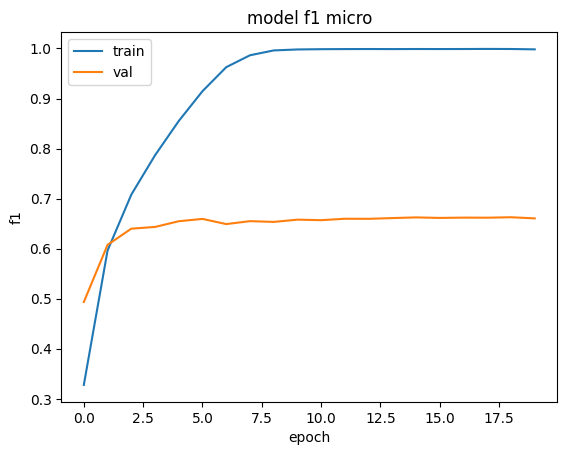

In [117]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
max(f1s_eval)

0.6539005716232587

In [60]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        self.relu = torch.nn.LeakyReLU()
        
        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.relu(self.conv(embedded))
        pooled = self.max_pool(convoluted)
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [62]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.2149543142318726; F1 measure: 0.267109375
Eval -  0.48663925272562086
1
Loss: 1.321739571094513; F1 measure: 0.5926171875
Eval -  0.6074727437916414
2
Loss: 0.8466409873962403; F1 measure: 0.7428125
Eval -  0.6378248504694125
3
Loss: 0.535114033818245; F1 measure: 0.838828125
Eval -  0.6478945052241065
4
Loss: 0.29885517358779906; F1 measure: 0.918984375
Eval -  0.6438474788007268
5
Loss: 0.137071426063776; F1 measure: 0.9717578125
Eval -  0.6463850034070261
6
Loss: 0.05590501617640257; F1 measure: 0.993984375
Eval -  0.6539076695941853
7
Loss: 0.024500186424702405; F1 measure: 0.998515625
Eval -  0.6552598330557238
8
Loss: 0.01374539923388511; F1 measure: 0.9988671875
Eval -  0.6594641978346457
9
Loss: 0.009622681476175786; F1 measure: 0.998515625
Eval -  0.6573572834645669


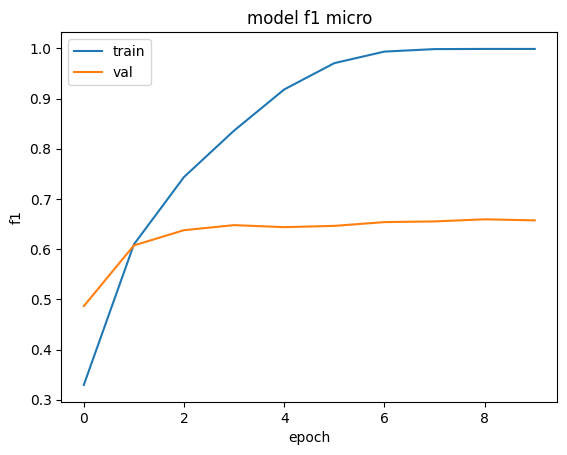

In [63]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
max(f1s_eval)

0.6594641978346457

Добавим батчнорм и регуляризацию.

In [103]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        # инициализируем батчнорм
        self.batch_norm = nn.BatchNorm1d(self.conv_length)

        
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        self.relu = torch.nn.LeakyReLU()
        

        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.conv(embedded)
        # я не нашел совсем достоверной информации, но пару авторитетных мнений
        # указывают на то, что батчнорм нужно ставить после свертки-пулинга-активации
        # а не где-то внутри этой тройки
        # то есть нужно держаться структуры свертка-*пулинг*-активация-батчнорм (пулинг опциональный)
        pooled = self.batch_norm(self.relu(self.max_pool(convoluted)))
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        
        return outputs



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam([{'params':model.fc_1.parameters()},
                        {'params':model.conv.parameters()},
                        {'params':model.embedding.parameters()},
                        {'params': model.fc.parameters(), 'weight_decay':0.1}],  # указываем в этом слое L2 регуляризацию
                                                                                 # можно пробовать значения как в sklearn
                                                                                 # в параметре C в логреге
                       
                         lr=0.001) # лернирг рейт тоже можно отдельно указать выше, но мы используем 1 на все слои
criterion = nn.CrossEntropyLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

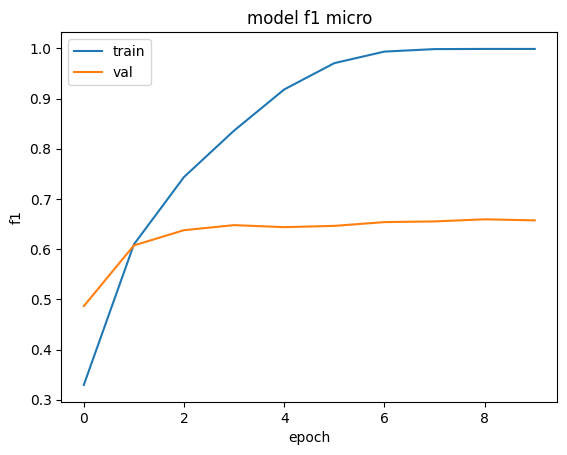

In [66]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
max(f1s_eval)

0.6594641978346457

### Несколько слоев с паддингом

Во всех сетках выше только 1 CNN слой и еще 1 доп. пулинг. Но рабочие сверточные сети это обычно десятки сверток и пулингов, которые наслаиваются друг на друга. Из когда выше видно, что собрать такую сетку будет непросто - будет очень много промежуточного когда для расчета размерностей. Чтобы этого избежать можно написать отдельный класс, который будет применять сверточный слой и сохранять длину последовательности. Для этого мы воспользуемся паддингом - добьем нулями исходную последовательность, чтобы на выходе получилась изначальная длина.

In [67]:
# созданный класс в торче можно использовать просто как слой!

class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channels, *, kernel_size = 5, stride = 1, ):
        
        super().__init__()          
        self.KERNEL_SIZE = kernel_size
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channels
        self.STRIDE = stride
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        """
        Раньше мы расчитывали длину, которая получится, после применения сверточного слоя  по формуле:
        OUTPUT_LENGTH = (((MAX_LEN-(KERNEL_SIZE-1)-1)/STRIDE)+1)
        
        
        Теперь мы хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN
        
        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2
        
        
        
        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        # допустим чтобы получить изначальную длину в 200
        # нужно добавить нулей до 210
        # тогда мы добавляем 5 нулей слева и 5 справа
        # ассерт выше выкинул бы ошибку если бы у нас получалось например 209, 
        # то есть мы не смогли бы ровно западить с 2 сторон
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2), 
                                                   int((EXP_LEN-MAX_LEN)/2)))
        
        convoluted = self.conv(padded)
        
        return self.act(convoluted)


class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # теперь слои удобно стакать
        # нужно только указывать OUT_CHANNELS как IN_CHANNELS в следующем слое
        self.conv = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS)
        self.conv1 = Conv_layer_with_pad(self.OUT_CHANNELS, 16)
        self.relu = nn.ReLU()
        # если бы мы поставили еще 1 слой, то его IN_CHANNELS была бы 16 и тд

        # длина сохраняется поэтому просто умножаем макс лен на OUT_CHANNELS последнего слоя
        self.flattened_size = int(self.MAX_LEN*16)
        
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        convoluted = self.relu(self.conv1(self.conv(embedded.permute(0, 2, 1))))
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = torch.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [69]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, train_data, optimizer, criterion, 100))
    evl = evaluate(model, valid_data, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x6400 and 3200x64)

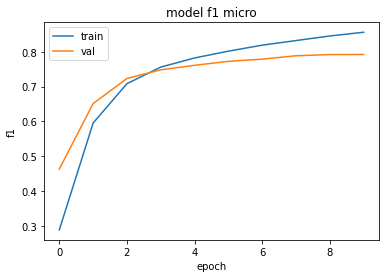

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [107]:
max(f1s_eval)

0.7343342911877394